
# Module 1 — Linear Regression (from scratch)

This notebook implements the full Module 1 assignment end‑to‑end:

- Load & preprocess the Facebook Metrics dataset
- Implement `bias_trick`, `train_test_split`
- Implement MSE, gradient, and a gradient descent trainer
- Plot train/test MSE across epochs
- (Bonus) Polynomial regression with L2 (weight decay) to fit non‑linear patterns

> Fill your name & ID below if required by your course.


In [ ]:

NAME = "David Dinh"
STUDENT_ID = "dd26"



## 0) Imports & utilities


In [2]:

# Core
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(144)

def shuffle_data(data: np.ndarray) -> None:
    """Shuffles the data in place (rows)."""
    np.random.shuffle(data)



## 1) Download and prepare the Facebook Metrics dataset

The original assignment uses the UCI Facebook metrics dataset. The next cell downloads
and unzips it to the current working directory, then:
- drops the non‑used columns per the spec
- normalizes all columns to [0,1]
- shuffles the rows once for reproducibility


In [3]:

# If you're running in an environment without internet, skip this cell and place the CSV
# next to this notebook as 'dataset_Facebook.csv'.
import os, zipfile, urllib.request

ZIP_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip"
ZIP_PATH = "Facebook_metrics.zip"
CSV_PATH = "dataset_Facebook.csv"

if not os.path.exists(CSV_PATH):
    try:
        print("Downloading dataset...")
        urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)
        print("Extracting...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as z:
            z.extractall("./")
    except Exception as e:
        print("Download failed (are you offline?). If so, make sure 'dataset_Facebook.csv' is present.")
        print(e)

# Load & clean
lr_dataframe = pd.read_csv(CSV_PATH, sep=';')
lr_dataframe.dropna(inplace=True)

columns_to_drop = [
    'Type','Lifetime Post Total Reach','Lifetime Post Total Impressions',
    'Lifetime Engaged Users','Lifetime Post Consumers','Lifetime Post Consumptions',
    'Lifetime Post Impressions by people who have liked your Page',
    'Lifetime Post reach by people who like your Page',
    'Lifetime People who have liked your Page and engaged with your post',
    'comment','like','share'
]
lr_dataframe.drop(columns=[c for c in columns_to_drop if c in lr_dataframe.columns], inplace=True)

# Normalize all remaining numeric columns to [0,1]
def normalize_col(col):
    if pd.api.types.is_numeric_dtype(col):
        rng = col.max() - col.min()
        return (col - col.min())/rng if rng != 0 else 0.0
    return col

lr_dataframe = lr_dataframe.apply(normalize_col)

# Numpy matrix (features + target)
lr_data = lr_dataframe.values.astype(float)

# Shuffle rows once for reproducibility
shuffle_data(lr_data)

# Quick peek
display(lr_dataframe.head())
print("Data shape (rows, cols):", lr_data.shape)


Extracting...


,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Total Interactions
0,1.0,0.5,1.0,0.500000,0.090909,0.0,0.015788
1,1.0,0.5,1.0,0.333333,0.409091,0.0,0.025892
2,1.0,1.0,1.0,0.333333,0.090909,0.0,0.012630
3,1.0,0.5,1.0,0.166667,0.409091,1.0,0.280549
4,1.0,0.5,1.0,0.166667,0.090909,0.0,0.062046


Data shape (rows, cols): (495, 7)



## 2) Split helpers (`bias_trick`, `separate_data`, `train_test_split`)


In [4]:

def bias_trick(X: np.ndarray) -> np.ndarray:
    """Augment X with a column of 1s as the first column (bias)."""
    ones = np.ones((X.shape[0], 1), dtype=X.dtype)
    return np.hstack((ones, X))

def separate_data(data: np.ndarray):
    """Split raw data into (X, y) and apply bias trick to X.
    Assumes the last column is the target 'Total Interactions' after cleaning.
    """
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    X = bias_trick(X)
    return X, y

def train_test_split(data: np.ndarray, train_size: float = 0.8):
    """Return X_train, y_train, X_test, y_test"""
    assert 0 < train_size < 1, "train_size must be in (0,1)"
    X, y = separate_data(data)
    n = X.shape[0]
    n_train = int(n * train_size)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test,  y_test  = X[n_train:], y[n_train:]
    return X_train, y_train, X_test, y_test

# Prepare splits
X_train, y_train, X_test, y_test = train_test_split(lr_data, train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((396, 7), (396, 1), (99, 7), (99, 1))


## 3) Loss, gradient, and a single GD step (MSE)


In [5]:

def mse(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Mean Squared Error."""
    assert y_pred.shape == y_true.shape
    return float(np.mean((y_pred - y_true)**2) / 2.0)  # /2 to match derivation

def mse_derivative(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """Gradient of MSE wrt theta (vectorized). X includes bias column."""
    # y_hat = X @ theta
    y_hat = X.dot(theta)
    # (1/n) * X^T (y_hat - y)
    n = X.shape[0]
    return (X.T.dot(y_hat - y)) / n

def gradient_descent_step(X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float) -> np.ndarray:
    grad = mse_derivative(X, y, theta)
    return theta - alpha * grad

def predict(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return X.dot(theta)



## 4) Training loop for Linear Regression


Epoch 1600/8000 | train MSE=0.002451 | test MSE=0.000413
Epoch 3200/8000 | train MSE=0.002289 | test MSE=0.000322
Epoch 4800/8000 | train MSE=0.002216 | test MSE=0.000296
Epoch 6400/8000 | train MSE=0.002182 | test MSE=0.000295
Epoch 8000/8000 | train MSE=0.002165 | test MSE=0.000300


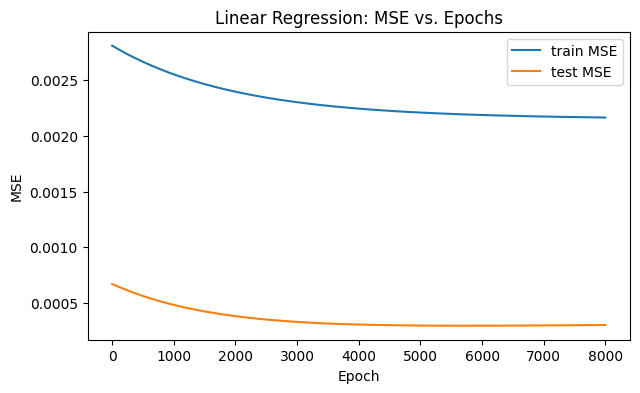

Final train MSE: 0.0021653466589839445
Final test  MSE: 0.000300226198596862
Theta shape: (7, 1)


In [6]:

def train_linear_regression(X_train, y_train, X_test, y_test, num_epochs=30000, alpha=5e-5):
    theta = np.zeros((X_train.shape[1], 1))
    train_errors, test_errors = [], []
    for epoch in range(num_epochs):
        # Forward
        y_hat_train = predict(X_train, theta)
        y_hat_test  = predict(X_test, theta)
        # Record errors
        train_errors.append(mse(y_hat_train, y_train))
        test_errors.append(mse(y_hat_test,  y_test))
        # One GD step
        theta = gradient_descent_step(X_train, y_train, theta, alpha)
        # (Optional) print progress sparsely
        if (epoch+1) % max(1, num_epochs//5) == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | train MSE={train_errors[-1]:.6f} | test MSE={test_errors[-1]:.6f}")
    return theta, np.array(train_errors), np.array(test_errors)

theta, train_errors, test_errors = train_linear_regression(X_train, y_train, X_test, y_test,
                                                           num_epochs=8000, alpha=1e-4)

plt.figure(figsize=(7,4))
plt.plot(train_errors, label="train MSE")
plt.plot(test_errors,  label="test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Linear Regression: MSE vs. Epochs")
plt.legend()
plt.show()

print("Final train MSE:", train_errors[-1])
print("Final test  MSE:", test_errors[-1])
print("Theta shape:", theta.shape)



## 5) (Bonus) Polynomial regression + L2 regularization (weight decay)

This section shows how to fit a **d‑degree polynomial** using the linear regression framework
plus L2 regularization to mitigate overfitting.


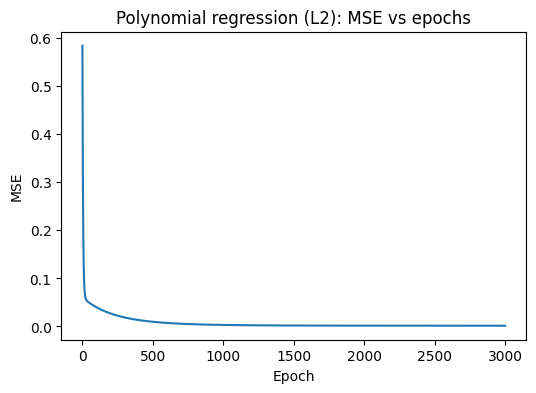

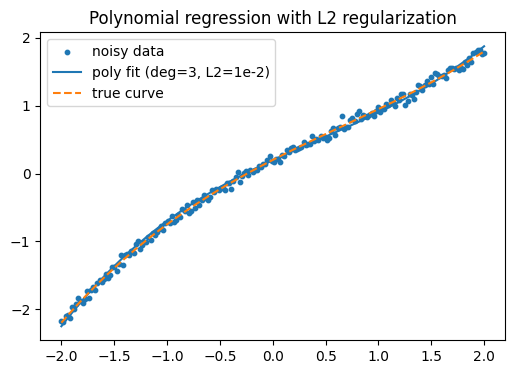

In [7]:

def make_poly_features(x1d: np.ndarray, degree: int) -> np.ndarray:
    """Given a 1D feature vector (N,), build [1, x, x^2, ..., x^d]."""
    X = np.ones((x1d.shape[0], degree+1))
    for d in range(1, degree+1):
        X[:, d] = x1d**d
    return X

def mse_derivative_l2(X: np.ndarray, y: np.ndarray, theta: np.ndarray, lam: float) -> np.ndarray:
    n = X.shape[0]
    # Gradient of (1/(2n))||Xθ - y||^2 + λ * sum_{j>=1} θ_j^2
    # Note: Do not regularize bias term (j=0)
    err = X.dot(theta) - y
    grad = (X.T.dot(err))/n
    reg = 2*lam*theta
    reg[0] = 0.0  # no reg on bias
    return grad + reg

def train_poly_l2(X, y, degree=4, lam=1e-3, alpha=1e-3, epochs=5000):
    # X is (N, 1) single feature; build polynomial feature matrix with bias
    Xp = make_poly_features(X.squeeze(), degree)
    theta = np.zeros((Xp.shape[1], 1))
    losses = []
    for t in range(epochs):
        y_hat = Xp.dot(theta)
        losses.append(mse(y_hat, y))
        theta -= alpha * mse_derivative_l2(Xp, y, theta, lam)
    return theta, Xp, np.array(losses)

# Demo with a synthetic 1D curve (since the FB data is multi‑dimensional):
rng = np.random.default_rng(33)
x = np.linspace(-2, 2, 200).reshape(-1,1)
y_true = 0.2 + 0.8*x - 0.1*(x**2) + 0.05*(x**3)
y = y_true + 0.05 * rng.normal(size=y_true.shape)

theta_poly, Xp, losses = train_poly_l2(x, y, degree=3, lam=1e-2, alpha=1e-2, epochs=3000)

plt.figure(figsize=(6,4))
plt.plot(losses); plt.title("Polynomial regression (L2): MSE vs epochs"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.show()

# Plot fit
x_plot = x.squeeze()
y_fit = Xp.dot(theta_poly).squeeze()

plt.figure(figsize=(6,4))
plt.scatter(x_plot, y.squeeze(), s=10, label="noisy data")
plt.plot(x_plot, y_fit, label="poly fit (deg=3, L2=1e-2)")
plt.plot(x_plot, y_true.squeeze(), label="true curve", linestyle="--")
plt.legend(); plt.title("Polynomial regression with L2 regularization"); plt.show()
